In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import time
from sklearn.utils import shuffle

In [63]:

#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model?.h5'
PATH_TO_MODELS = "Models/"


#dataset
CSV_PATH = "Datasets/"
CSV_NAME = "AirIQ1dataset.csv"
features_considered = ['temperature','humidite','IQ','IQ_J+1']

#training
EPOCHS = 5
KFOLD = 6

#LSTM
NB_MEASURES = 8
SIZE_GRU = 8

#Seed
RANDOM_SHUFFLE_SEED = 0

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

                  temperature  humidite   IQ  IQ_J+1
Date                                                
01/12/2019 12:00     0.309459      0.75  0.6       5
01/12/2019 15:00     0.314527      0.72  0.6       5
01/12/2019 18:00     0.297635      0.76  0.6       5
01/12/2019 21:00     0.268919      0.84  0.6       5
30/11/2019 00:00     0.280743      0.94  0.4       6


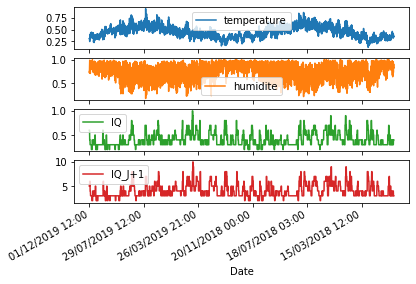

In [64]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')

features = df[features_considered]
features.index = df['Date']

#normalize
features['temperature'] = features['temperature'].apply(lambda x: (x - (-12.30))/((46.90)-(-12.30)))
features['humidite'] = features['humidite'].apply(lambda x: x/100)
features['IQ'] = features['IQ'].apply(lambda x: x/10)

print(features.head())
features.plot(subplots=True)
plt.show()

dataset = features.values

In [65]:
def createTraining(dataset,nb_measures,index_features_in):
    """
    shape the trainning dataset
    """
    # on va decouper le dataset en tranches de nb_measures:
    chunks = [dataset[x:x+nb_measures] for x in range(0, len(dataset), nb_measures)]
    del chunks[-1] # ddelete the last one as it may be inferior to nb_measures
    chunks = np.array(chunks)  
    x_train = chunks[:,:,0:index_features_in]
    y_train = chunks[:,0,-1]
    x_train,y_train = shuffle(x_train,y_train, random_state=RANDOM_SHUFFLE_SEED)
    return(x_train, y_train)

def kFold(x,y,k):
    """
    create what we need for cross validation
    """
    foldSize = int(len(x)/k)
    x_fold = []
    y_fold = []
    for i in range(k):
        x_fold.append(x[i*foldSize:(1+i)*foldSize])
        y_fold.append(y[i*foldSize:(1+i)*foldSize])
    return(x_fold,y_fold)   

In [66]:
x_train,y_train = createTraining(dataset,NB_MEASURES,len(features_considered)-1)
x_fold, y_fold = kFold(x_train,y_train,KFOLD)

In [67]:
OPTIMIZER=tf.optimizers.RMSprop(learning_rate=0.005)
LOSS='mae'

if LOAD_MODEL:
    model = keras.models.load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(SIZE_GRU,input_shape=input_shape,name='GRU_layer',go_backwards=True))
    model.add(tf.keras.layers.Dense(1,name="Dense_layer"))
    model.compile(optimizer=OPTIMIZER, loss=LOSS)
    model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_layer (GRU)              (None, 8)                 312       
_________________________________________________________________
Dense_layer (Dense)          (None, 1)                 9         
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [68]:
for i in range(len(x_fold)):
    x = []
    y = []
    for j in range(len(x_fold)):
        if i!=j:
            if len(x)>0:
                x = np.concatenate([x,x_fold[j]],axis=0)
                y = np.concatenate([y,y_fold[j]],axis=0)
            else:
                x=x_fold[j]
                y=y_fold[j]
                
    history = model.fit(x,
                        y,
                        epochs=EPOCHS)
    #steps_per_epoch=len(x_train)

Train on 580 samples
Epoch 1/5
580/580 [==============================] - 1s 2ms/sample - loss: 2.4376
Epoch 2/5
580/580 [==============================] - 0s 158us/sample - loss: 1.1061
Epoch 3/5
580/580 [==============================] - 0s 151us/sample - loss: 1.0544
Epoch 4/5
580/580 [==============================] - 0s 139us/sample - loss: 1.0420
Epoch 5/5
580/580 [==============================] - 0s 136us/sample - loss: 1.0411
Train on 580 samples
Epoch 1/5
580/580 [==============================] - 0s 136us/sample - loss: 1.0239
Epoch 2/5
580/580 [==============================] - 0s 120us/sample - loss: 1.0089
Epoch 3/5
580/580 [==============================] - 0s 117us/sample - loss: 0.9728
Epoch 4/5
580/580 [==============================] - 0s 119us/sample - loss: 0.9443
Epoch 5/5
580/580 [==============================] - 0s 127us/sample - loss: 0.9110
Train on 580 samples
Epoch 1/5
580/580 [==============================] - 0s 139us/sample - loss: 0.9033
Epoch 2/5
580/5

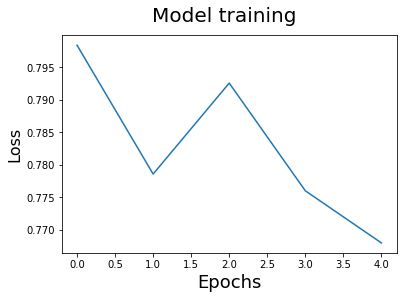

OSError: Unable to create file (unable to open file: name = 'Models/model1584976443.1143308.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [69]:
if len(history.history['loss'])>1:
    # plot history
    plt.plot(history.history['loss'], label='loss')
    plt.suptitle('Model training', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    
name = "model"+str(time.time())
model.save(PATH_TO_MODELS+ name+".h5")

In [70]:
def calc_accuracy(y_pred,y_true):
    """
    calculate the accurracy of the prediction according to the true value
    """
    count=0
    for i in range(0,len(y_true)):
        if y_true[i]==round(y_pred[i][0]):
            count+=1
    if count==0:
        return(0)
    return(count/len(y_true)*100)
    
def mean_error(y_pred,y_true):
    """
    calculate the mean error between the prediction and the true value
    """
    total_error=0
    for i in range(0,len(y_true)):
        total_error += abs(y_true[i] - y_pred[i][0])
    return(total_error/len(y_true))

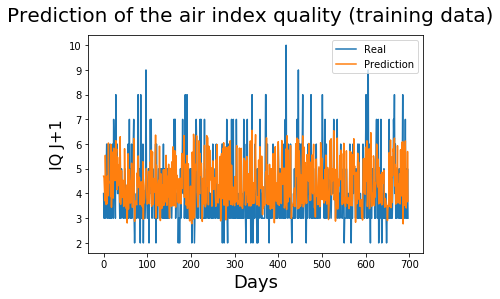

Accuracy with training data: 34.81 %
Mean error with training data: 0.86


In [71]:
y_pred_train = model.predict(x_train)

plt.plot(y_train, label='Real')
plt.plot(y_pred_train, label='Prediction')
plt.suptitle('Prediction of the air index quality (training data)', fontsize=20)
plt.xlabel('Days', fontsize=18)
plt.ylabel('IQ J+1', fontsize=16)
plt.legend()
plt.show()

print("Accuracy with training data:", round(calc_accuracy(y_pred_train,y_train),2) ,"%")
print("Mean error with training data:", round(mean_error(y_pred_train,y_train),2))